In [99]:
import json 
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math 
import numpy as np
import pickle


In [100]:
# Get the current directory (where your Python script is located)
current_directory = os.path.dirname('Outlier investigation')

csv_file_path = os.path.join(current_directory, 'DB_Macchinine', 'Dati Pow Aggregati','DATA_DBMACCHINE_AGGREGATI_BASELINE_FOCUS.csv')
print(csv_file_path) 

df = pd.read_csv(csv_file_path)

df.head(100000)

DB_Macchinine\Dati Pow Aggregati\DATA_DBMACCHINE_AGGREGATI_BASELINE_FOCUS.csv


,UserID,Phase,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,...,T8_Theta,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma
0,M28,Baseline,2.491,2.108,0.544,2.437,0.562,1.331,0.485,0.487,...,1.720,1.423,1.564,4.624,1.890,4.469,2.610,0.486,2.134,0.673
1,M28,Baseline,2.569,2.127,0.651,2.522,0.567,1.193,0.401,0.616,...,1.719,1.378,1.534,3.993,1.575,4.383,2.534,0.490,2.117,0.685
2,M28,Baseline,2.562,2.233,0.876,2.536,0.595,1.098,0.317,0.745,...,1.710,1.440,1.466,3.279,1.221,4.062,2.544,0.627,2.064,0.718
3,M28,Baseline,2.476,2.419,1.160,2.468,0.655,1.143,0.274,0.865,...,1.634,1.596,1.365,2.691,0.932,3.547,2.690,0.827,1.983,0.780
4,M28,Baseline,2.501,2.645,1.439,2.328,0.740,1.304,0.311,0.978,...,1.524,1.821,1.257,2.340,0.761,3.215,2.957,1.040,1.886,0.855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67188,M30,Sudoku,0.805,1.104,0.606,0.446,0.169,0.346,0.678,0.460,...,0.841,0.575,0.741,0.563,0.271,1.558,0.987,0.486,0.331,0.212
67189,M30,Sudoku,0.897,1.082,0.590,0.452,0.180,0.352,0.745,0.464,...,0.802,0.387,0.694,0.553,0.261,1.800,1.037,0.494,0.356,0.221
67190,M30,Sudoku,1.092,1.033,0.564,0.442,0.188,0.370,0.790,0.478,...,0.795,0.252,0.642,0.516,0.250,2.072,1.038,0.515,0.372,0.226
67191,M30,Sudoku,1.323,0.905,0.534,0.421,0.189,0.393,0.788,0.503,...,0.836,0.179,0.587,0.464,0.244,2.384,0.970,0.537,0.378,0.225


In [101]:
import math

def process_and_find_outliers(df, a):
    data_columns = [
        'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
        'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
        'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
        'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
        'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
    ]

    # Conversion to float64
    df[data_columns] = df[data_columns].astype(float)

    # Apply logarithm
    df.loc[:, data_columns] = df.loc[:, data_columns].apply(lambda x: x.apply(lambda y: math.log(y + 1)))

    # Subtract average baseline value for each specific user
    label_column = 'Phase'
    user_id_column = 'UserID'

    # Get the unique user IDs
    user_ids = df[user_id_column].unique()

    # Process the data for each user ID
    for user_id in user_ids:
        print(f"Processing user ID: {user_id}")  # Print the current user ID

        # Get the rows for the current user ID
        user_rows = df[df[user_id_column] == user_id]

        # Calculate the average value for each specified column, for rows with the label 'baseline'
        baseline_rows = user_rows[user_rows[label_column] == 'Baseline']
        if baseline_rows.empty:
            print(f"No 'baseline' rows for user ID: {user_id}")  # Print a message if there are no 'baseline' rows
            continue
        averages = baseline_rows[data_columns].mean()

        # Subtract the average value from each column, for rows with the current user ID
        for column in data_columns:
            df.loc[user_rows.index, column] -= averages[column]

    # Find and print outliers
    outlier_rows = set()  # Set to store the indices of rows with at least one outlier
    boundaries = {}

    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:  # Check if the column is numeric
            Q1 = df[column].quantile(0.25)  # First quartile (25%)
            Q3 = df[column].quantile(0.75)  # Third quartile (75%)
            IQR = Q3 - Q1  # Interquartile range

            # Define the range for outliers
            lower_bound = Q1 - a * IQR
            upper_bound = Q3 + a * IQR

            # Find the outliers
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

            # Print the percentage of outliers
            print(f'Percentage of outliers in {column}: {len(outliers) / len(df) * 100}%')

            # Add the indices of the outlier rows to the set
            outlier_rows.update(outliers.index)

            # Store the boundaries
            boundaries[column] = (lower_bound, upper_bound)

    # Print the number of rows with at least one outlier
    print(f'Percentage of rows with at least one outlier: {len(outlier_rows) / len(df) * 100}%')
    df.drop(outlier_rows, inplace=True)

    return df, boundaries

In [102]:
processed_df, boundaries = process_and_find_outliers(df, 1.5)

Processing user ID: M28
Processing user ID: F44
Processing user ID: F25
Processing user ID: M23
Processing user ID: F24
Processing user ID: F20
Processing user ID: F23
Processing user ID: M21
Processing user ID: M22
Processing user ID: M25
Processing user ID: F28
Processing user ID: M29
Processing user ID: M26
Processing user ID: F26
Processing user ID: M27
Processing user ID: F27
Processing user ID: F60
Processing user ID: M30
Percentage of outliers in AF3_Theta: 2.8380932537615524%
Percentage of outliers in AF3_Alpha: 3.742949414373521%
Percentage of outliers in AF3_BetaL: 3.9825577069039926%
Percentage of outliers in AF3_BetaH: 7.279032042028187%
Percentage of outliers in AF3_Gamma: 11.048769961156669%
Percentage of outliers in T7_Theta: 7.729971872070007%
Percentage of outliers in T7_Alpha: 6.333993124283779%
Percentage of outliers in T7_BetaL: 5.665768755673954%
Percentage of outliers in T7_BetaH: 6.807256708288066%
Percentage of outliers in T7_Gamma: 9.267334394951856%
Percentage

In [103]:
processed_df = processed_df[processed_df['UserID'] != 'F44']

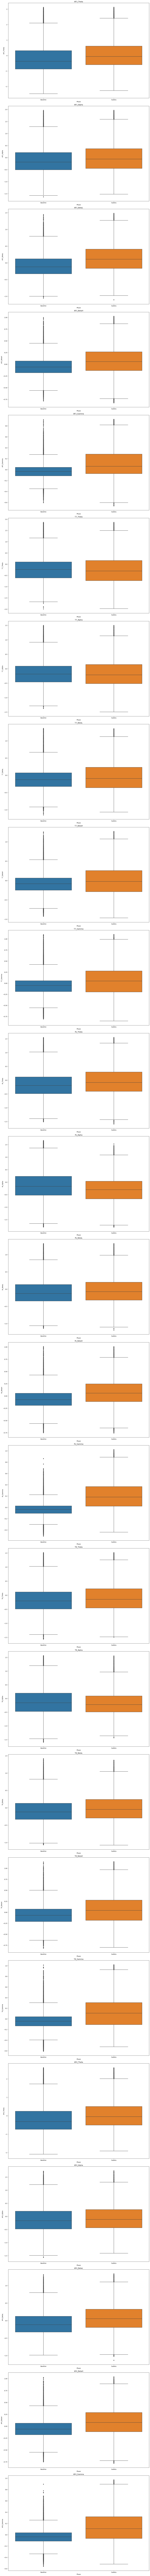

In [104]:
# Assuming filtered_df is your DataFrame and columns is the list of columns
columns = [
    'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
    'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
    'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
    'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
    'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
]

# Set the size of the entire plot
plt.figure(figsize=(15,256))

# Number of rows and columns for subplots
n_rows = 25
n_cols = 1

# Create subplots
for i, column in enumerate(columns, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=processed_df, x="Phase", y=column)
    plt.title(column)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig("output_plots_subMerged.pdf")

# Show the plot
plt.show()

In [105]:
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity

def calculate_kl_divergence(df, columns):
    kl_divergence = {}

    # Split the DataFrame into baseline and focus
    df_baseline = df[df['Phase'] == 'Baseline']
    df_focus = df[df['Phase'] == 'Sudoku']

    # Estimate the density of each column using KDE
    for column in columns:
        if column in df_baseline and column in df_focus:
            # Fit KDE to the baseline and focus values
            kde_baseline = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(df_baseline[column].values[:, None])
            kde_focus = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(df_focus[column].values[:, None])

            # Calculate the scores for a range of values
            x = np.linspace(df[column].min(), df[column].max(), 1000)
            log_prob_baseline = kde_baseline.score_samples(x[:, None])
            log_prob_focus = kde_focus.score_samples(x[:, None])

            # Calculate the KL divergence
            kl_div = entropy(np.exp(log_prob_baseline), qk=np.exp(log_prob_focus))

            kl_divergence[column] = kl_div

    return kl_divergence

In [106]:
data_columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
                'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
                'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
                'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
                'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

kl = calculate_kl_divergence(processed_df,data_columns)

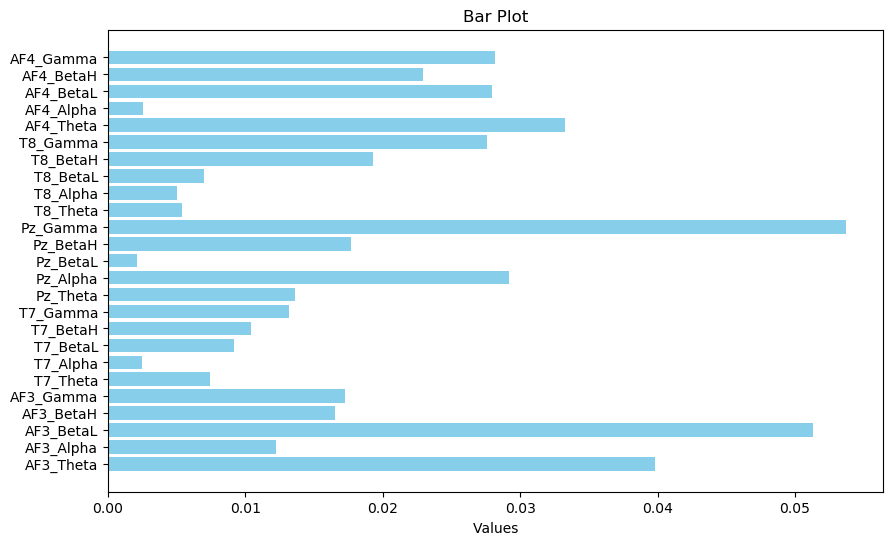

In [107]:
plt.figure(figsize=(10, 6))
plt.barh(list(kl.keys()), list(kl.values()), color='skyblue')
plt.xlabel('Values')
plt.title('Bar Plot')
plt.show()

# SUB 0005 AND 0006

In [120]:
# Get the current directory (where your Python script is located)
current_directory = os.path.dirname('Outlier investigation')
# Initialize an empty list to store the rows
rows = []
# Iterate through all the JSON files in the specified range

# Generate the file name (assuming the format is POWxxx.json)
json_file_name = f'esperimento_0005_FV_.json'
print(json_file_name)
json_file_path =json_file_name;
# Check if the file exists before attempting to read it
if os.path.exists(json_file_path):
    print(json_file_name)
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    # Iterate through the JSON data
    for key, value in data.items():
        user_id = value['UserID']
        readings = value['Readings']
        for reading_key, reading_value in readings.items():
            phase = reading_value['Phase']
            if phase in ["sudoku", "baseline"]:
                time = reading_value['Time']
                af3_theta = reading_value['AF3']['Theta']
                af3_alpha = reading_value['AF3']['Alpha']
                af3_betaL = reading_value['AF3']['BetaL']
                af3_betaH = reading_value['AF3']['BetaH']
                af3_gamma = reading_value['AF3']['Gamma']

                t7_theta = reading_value['T7']['Theta']
                t7_alpha = reading_value['T7']['Alpha']
                t7_betaL = reading_value['T7']['BetaL']
                t7_betaH = reading_value['T7']['BetaH']
                t7_gamma = reading_value['T7']['Gamma']

                pz_theta = reading_value['Pz']['Theta']
                pz_alpha = reading_value['Pz']['Alpha']
                pz_betaL = reading_value['Pz']['BetaL']
                pz_betaH = reading_value['Pz']['BetaH']
                pz_gamma = reading_value['Pz']['Gamma']

                t8_theta = reading_value['T8']['Theta']
                t8_alpha = reading_value['T8']['Alpha']
                t8_betaL = reading_value['T8']['BetaL']
                t8_betaH = reading_value['T8']['BetaH']
                t8_gamma = reading_value['T8']['Gamma']

                af4_theta = reading_value['AF4']['Theta']
                af4_alpha = reading_value['AF4']['Alpha']
                af4_betaL = reading_value['AF4']['BetaL']
                af4_betaH = reading_value['AF4']['BetaH']
                af4_gamma = reading_value['AF4']['Gamma']


                row = [user_id, phase, time, af3_theta, af3_alpha, af3_betaL, af3_betaH, af3_gamma, t7_theta, t7_alpha, t7_betaL, t7_betaH, t7_gamma,
                       pz_theta, pz_alpha, pz_betaL, pz_betaH, pz_gamma, t8_theta, t8_alpha, t8_betaL, t8_betaH, t8_gamma,
                       af4_theta, af4_alpha, af4_betaL, af4_betaH, af4_gamma]

                rows.append(row)

# Define columns as before
columns = ['UserID', 'Phase', 'Time', 'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma', 
           'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma', 
           'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma', 
           'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma', 
           'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

# Create a DataFrame from the rows and columns
df = pd.DataFrame(rows, columns=columns)

esperimento_0005_FV_.json
esperimento_0005_FV_.json


In [109]:
df['Phase'] = df['Phase'].replace({"sudoku": "Sudoku", "baseline": "Baseline"})

In [110]:
df

,UserID,Phase,Time,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,...,T8_Theta,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma
0,sub0005,Baseline,10:16:28.780,4.481,2.312,0.861,0.391,0.274,3.899,2.011,...,4.702,3.73,3.534,1.953,1.567,9.129,3.63,1.539,0.666,0.34
1,sub0005,Baseline,10:16:29.780,4.397,2.421,0.908,0.412,0.283,4.089,1.923,...,4.526,4.215,3.051,1.978,1.71,8.765,3.8,1.577,0.679,0.352
2,sub0005,Baseline,10:16:29.780,4.516,2.426,0.914,0.426,0.279,4.166,1.76,...,4.545,4.879,2.892,1.962,1.829,7.957,3.957,1.575,0.661,0.354
3,sub0005,Baseline,10:16:29.780,5.008,2.35,0.906,0.424,0.262,4.307,1.604,...,4.995,5.541,3.193,1.955,1.894,7.132,4.114,1.56,0.606,0.344
4,sub0005,Baseline,10:16:29.780,6.017,2.245,0.92,0.41,0.237,4.827,1.514,...,6.043,5.967,3.919,2.013,1.892,6.632,4.237,1.556,0.522,0.323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,sub0005,Sudoku,10:35:41.690,134.915,11.578,5.206,2.581,1.996,0.837,0.706,...,6.245,1.859,4.436,2.365,2.55,66.25,6.827,5.447,3.138,1.809
1612,sub0005,Sudoku,10:35:41.690,74.106,7.05,4.409,2.473,2.186,0.864,0.709,...,3.898,1.791,3.327,2.224,2.801,36.086,5.135,5.672,3.091,1.972
1613,sub0005,Sudoku,10:35:41.690,31.157,4.398,4.054,2.452,2.254,0.862,0.676,...,2.522,2.025,2.465,2.205,2.915,15.033,4.235,6.08,3.019,2.061
1614,sub0005,Sudoku,10:35:41.690,9.517,3.275,4.058,2.463,2.158,0.816,0.635,...,2.207,2.378,2.11,2.304,2.847,4.53,3.788,6.498,2.857,2.036


In [111]:
processed_df2, boundaries2 = process_and_find_outliers(df, 1.5)

Processing user ID: sub0005
Percentage of outliers in AF3_Theta: 6.435643564356436%
Percentage of outliers in AF3_Alpha: 2.2896039603960396%
Percentage of outliers in AF3_BetaL: 1.2995049504950495%
Percentage of outliers in AF3_BetaH: 0.0%
Percentage of outliers in AF3_Gamma: 0.0%
Percentage of outliers in T7_Theta: 6.002475247524752%
Percentage of outliers in T7_Alpha: 3.527227722772277%
Percentage of outliers in T7_BetaL: 5.9405940594059405%
Percentage of outliers in T7_BetaH: 11.262376237623762%
Percentage of outliers in T7_Gamma: 11.014851485148515%
Percentage of outliers in Pz_Theta: 2.0420792079207923%
Percentage of outliers in Pz_Alpha: 1.1757425742574257%
Percentage of outliers in Pz_BetaL: 1.1757425742574257%
Percentage of outliers in Pz_BetaH: 0.12376237623762376%
Percentage of outliers in Pz_Gamma: 0.0%
Percentage of outliers in T8_Theta: 1.670792079207921%
Percentage of outliers in T8_Alpha: 2.5371287128712874%
Percentage of outliers in T8_BetaL: 0.3094059405940594%
Percent

In [112]:
boundaries

{'AF3_Theta': (-2.977240379192429, 3.119057514634104),
 'AF3_Alpha': (-1.8532143745166187, 1.9660666860427884),
 'AF3_BetaL': (-1.253817532277903, 1.4807243633190388),
 'AF3_BetaH': (-0.8255127721310803, 1.021548038037119),
 'AF3_Gamma': (-0.6798032808798166, 0.9176120159425727),
 'T7_Theta': (-2.015239529263519, 1.8562371045011614),
 'T7_Alpha': (-1.5403968848797185, 1.496718083819962),
 'T7_BetaL': (-1.2524493918024802, 1.3590302476514067),
 'T7_BetaH': (-1.0973427953196744, 1.2681884531547647),
 'T7_Gamma': (-0.8852581230260246, 1.0990893921455045),
 'Pz_Theta': (-1.594179796534568, 1.5441437287643258),
 'Pz_Alpha': (-1.7978097514777922, 1.6608099761754829),
 'Pz_BetaL': (-1.2435545502675158, 1.3207674220168837),
 'Pz_BetaH': (-0.8144663346637989, 1.0084034789847518),
 'Pz_Gamma': (-0.6996189722497531, 1.024476693500187),
 'T8_Theta': (-1.5982211254158105, 1.5109939642194967),
 'T8_Alpha': (-1.598250158173931, 1.5706008287943074),
 'T8_BetaL': (-1.268106140899049, 1.4182017172640493

In [113]:
boundaries2

{'AF3_Theta': (-1.8881612687830658, 1.8469920134792495),
 'AF3_Alpha': (-1.5721396528023883, 1.4861885560776775),
 'AF3_BetaL': (-1.091242819205738, 1.2675715826281095),
 'AF3_BetaH': (-1.2999944512963084, 1.7643069788329222),
 'AF3_Gamma': (-1.470843802717672, 2.2267220494953963),
 'T7_Theta': (-1.6826025776547513, 1.623587756059938),
 'T7_Alpha': (-1.4479493127632548, 1.388553738872906),
 'T7_BetaL': (-0.9072601170086121, 0.8871645414253124),
 'T7_BetaH': (-0.6139392520670968, 0.6785609704987389),
 'T7_Gamma': (-0.417084671819068, 0.5383377991402523),
 'Pz_Theta': (-1.1112778296263304, 1.1301514404009911),
 'Pz_Alpha': (-2.0567815702231806, 1.4753916770093298),
 'Pz_BetaL': (-1.3805234987840875, 1.2292475844491528),
 'Pz_BetaH': (-1.2472082863336242, 1.628459098931298),
 'Pz_Gamma': (-1.5664672395035877, 2.4517911982835066),
 'T8_Theta': (-1.0937105322568987, 0.9917671774458884),
 'T8_Alpha': (-1.1716143733823978, 0.9890739207759613),
 'T8_BetaL': (-1.114801642084483, 1.1491520792175

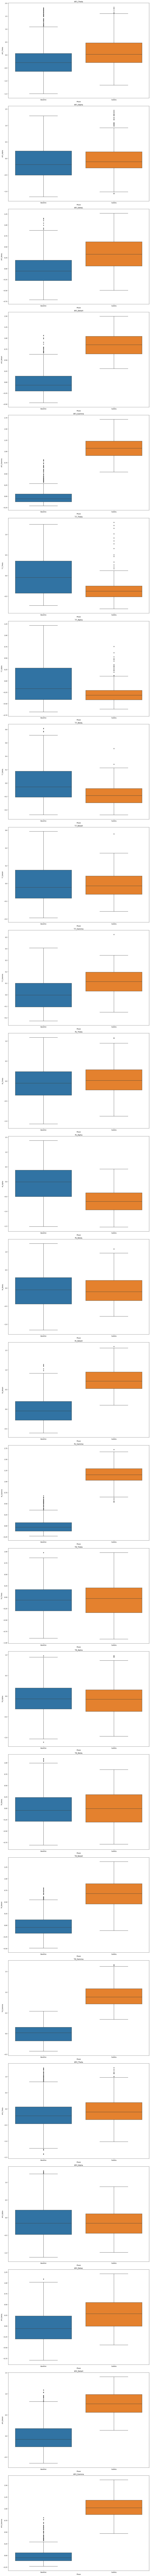

In [114]:
# Assuming filtered_df is your DataFrame and columns is the list of columns
columns = [
    'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
    'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
    'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
    'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
    'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
]

# Set the size of the entire plot
plt.figure(figsize=(15,256))

# Number of rows and columns for subplots
n_rows = 25
n_cols = 1

# Create subplots
for i, column in enumerate(columns, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=processed_df2, x="Phase", y=column)
    plt.title(column)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [115]:
data_columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
                'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
                'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
                'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
                'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

kl2 = calculate_kl_divergence(processed_df2,data_columns)

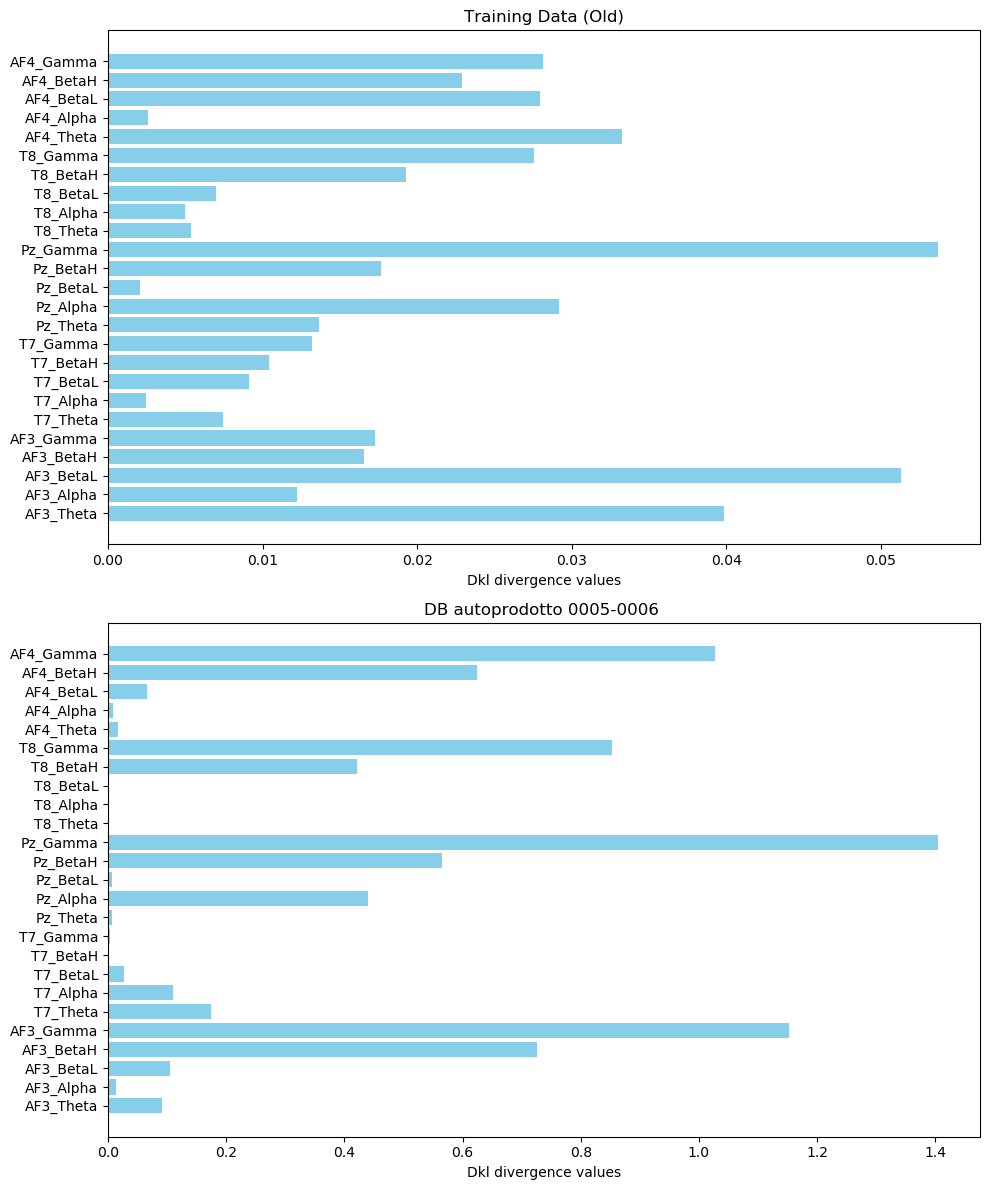

In [118]:
fig, axs = plt.subplots(2, figsize=(10, 12))

# First subplot
axs[0].barh(list(kl.keys()), list(kl.values()), color='skyblue')
axs[0].set_xlabel('Dkl divergence values')
axs[0].set_title('Training Data (Old)')

# Second subplot
axs[1].barh(list(kl2.keys()), list(kl2.values()), color='skyblue')
axs[1].set_xlabel('Dkl divergence values')
axs[1].set_title('DB autoprodotto 0005-0006 ')

plt.tight_layout()
plt.show()

# SUB 0008

In [124]:
# Initialize an empty list to store the rows
rows = []
# Iterate through all the JSON files in the specified range

# Generate the file name (assuming the format is POWxxx.json)
json_file_name = f'esperimento_0008_FV_.json'
print(json_file_name)
json_file_path =json_file_name;
# Check if the file exists before attempting to read it
if os.path.exists(json_file_path):
    print(json_file_name)
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    # Iterate through the JSON data
    for key, value in data.items():
        user_id = value['UserID']
        readings = value['Readings']
        for reading_key, reading_value in readings.items():
            phase = reading_value['Phase']
            if phase in ["sudoku", "baseline"]:
                time = reading_value['Time']
                af3_theta = reading_value['AF3']['Theta']
                af3_alpha = reading_value['AF3']['Alpha']
                af3_betaL = reading_value['AF3']['BetaL']
                af3_betaH = reading_value['AF3']['BetaH']
                af3_gamma = reading_value['AF3']['Gamma']

                t7_theta = reading_value['T7']['Theta']
                t7_alpha = reading_value['T7']['Alpha']
                t7_betaL = reading_value['T7']['BetaL']
                t7_betaH = reading_value['T7']['BetaH']
                t7_gamma = reading_value['T7']['Gamma']

                pz_theta = reading_value['Pz']['Theta']
                pz_alpha = reading_value['Pz']['Alpha']
                pz_betaL = reading_value['Pz']['BetaL']
                pz_betaH = reading_value['Pz']['BetaH']
                pz_gamma = reading_value['Pz']['Gamma']

                t8_theta = reading_value['T8']['Theta']
                t8_alpha = reading_value['T8']['Alpha']
                t8_betaL = reading_value['T8']['BetaL']
                t8_betaH = reading_value['T8']['BetaH']
                t8_gamma = reading_value['T8']['Gamma']

                af4_theta = reading_value['AF4']['Theta']
                af4_alpha = reading_value['AF4']['Alpha']
                af4_betaL = reading_value['AF4']['BetaL']
                af4_betaH = reading_value['AF4']['BetaH']
                af4_gamma = reading_value['AF4']['Gamma']


                row = [user_id, phase, time, af3_theta, af3_alpha, af3_betaL, af3_betaH, af3_gamma, t7_theta, t7_alpha, t7_betaL, t7_betaH, t7_gamma,
                       pz_theta, pz_alpha, pz_betaL, pz_betaH, pz_gamma, t8_theta, t8_alpha, t8_betaL, t8_betaH, t8_gamma,
                       af4_theta, af4_alpha, af4_betaL, af4_betaH, af4_gamma]

                rows.append(row)

# Define columns as before
columns = ['UserID', 'Phase', 'Time', 'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma', 
           'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma', 
           'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma', 
           'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma', 
           'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

# Create a DataFrame from the rows and columns
df = pd.DataFrame(rows, columns=columns)

df['Phase'] = df['Phase'].replace({"sudoku": "Sudoku", "baseline": "Baseline"})
processed_df3, boundaries3 = process_and_find_outliers(df, 1.5)

esperimento_0008_FV_.json
esperimento_0008_FV_.json
Processing user ID: sub0008
Percentage of outliers in AF3_Theta: 5.208333333333334%
Percentage of outliers in AF3_Alpha: 4.791666666666667%
Percentage of outliers in AF3_BetaL: 1.6666666666666667%
Percentage of outliers in AF3_BetaH: 2.8125%
Percentage of outliers in AF3_Gamma: 2.3958333333333335%
Percentage of outliers in T7_Theta: 1.875%
Percentage of outliers in T7_Alpha: 3.125%
Percentage of outliers in T7_BetaL: 1.4583333333333333%
Percentage of outliers in T7_BetaH: 0.7291666666666666%
Percentage of outliers in T7_Gamma: 1.25%
Percentage of outliers in Pz_Theta: 1.875%
Percentage of outliers in Pz_Alpha: 0.7291666666666666%
Percentage of outliers in Pz_BetaL: 0.7291666666666666%
Percentage of outliers in Pz_BetaH: 0.9375%
Percentage of outliers in Pz_Gamma: 1.5625%
Percentage of outliers in T8_Theta: 0.4166666666666667%
Percentage of outliers in T8_Alpha: 1.25%
Percentage of outliers in T8_BetaL: 1.6666666666666667%
Percentage o

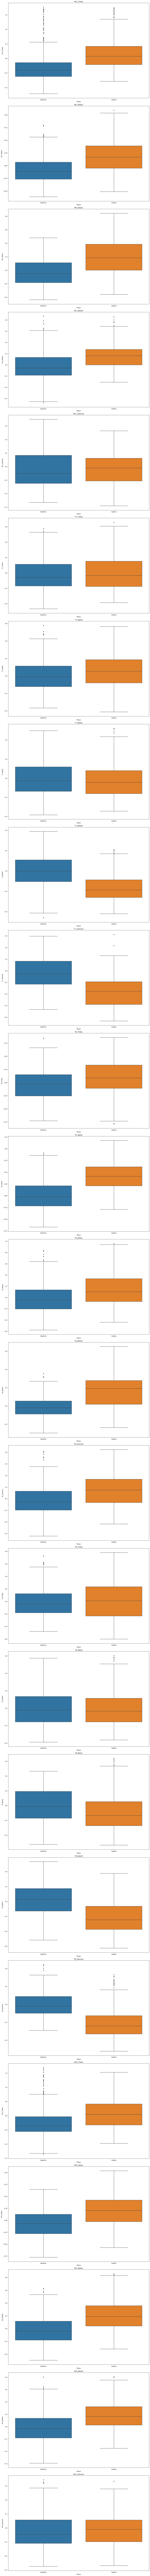

In [125]:
# Assuming filtered_df is your DataFrame and columns is the list of columns
columns = [
    'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
    'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
    'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
    'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
    'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
]

# Set the size of the entire plot
plt.figure(figsize=(15,256))

# Number of rows and columns for subplots
n_rows = 25
n_cols = 1

# Create subplots
for i, column in enumerate(columns, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=processed_df3, x="Phase", y=column)
    plt.title(column)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()